In [1]:
import itertools
from cwgp.grid_search import grid_search
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import GPy
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import scipy
from sklearn.model_selection import KFold

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
def poly(x, *par):
    return np.polyval(par,x)

In [4]:
def exp(x, *par):
    return par[0]*np.exp(par[1]*x)

In [5]:
def const(x, *par):
    return 0

In [6]:
def gp(x_train, y_train, kernel, mean_function, init_params):
    res = scipy.optimize.curve_fit(
        mean_function,  np.ravel(x_train), np.ravel(y_train), p0=init_params, maxfev=3000)
    par = res[0]
    print(f"params:{par}")
    mf = GPy.core.Mapping(1,1)
    mf.f = lambda x: mean_function(x, *par)
    mf.update_gradients = lambda a,b: None
    
    model = GPy.models.GPRegression(x_train, y_train, mean_function=mf, kernel=kernel)
    model.optimize()
    return model

In [7]:
def draw(domain, y_mean, y_top, y_bot, x_train, y_train, x_val, y_val, x_test, y_test, subplot, ylim=False):
    subplot.fill_between(domain, np.ravel(y_top), np.ravel(y_bot), color=(0,0.5,0.5,0.2), label="Confidence")
    subplot.scatter(x_train, y_train, marker="x", color='black', label="train")
    subplot.scatter(x_val, y_val, marker="x", color='red', label="validate")
    subplot.scatter(x_test, y_test, marker="x", color='blue', label="test")
    subplot.plot(domain, y_mean, label="mean")
    if ylim:
        subplot.set_ylim(ylim)       
    subplot.grid(True)
    subplot.legend()


In [8]:
def cwgp_regression(**kwargs):
    x_train, y_train, x_val, y_val = kwargs["x_train"], kwargs["y_train"], kwargs["x_val"], kwargs["y_val"]
    x_test, y_test = kwargs["x_test"], kwargs["y_test"]
    model_holder = kwargs["model_holder"]
    ylim = kwargs["ylim"]
    
    cwgp_y_train = y_train
    cwgp_y_val = y_val
    cwgp_y_test = y_test
    
    for cwgp_model in model_holder:
        cwgp_y_train, y_d = cwgp_model.phi.comp_phi(
                cwgp_model.phi.res.x, cwgp_y_train)
        
        cwgp_y_val, d = cwgp_model.phi.comp_phi(
                cwgp_model.phi.res.x, cwgp_y_val)
        
        cwgp_y_test, d = cwgp_model.phi.comp_phi(
                cwgp_model.phi.res.x, cwgp_y_test)
    import seaborn as sns
    
    sns.distplot(np.concatenate([cwgp_y_train , cwgp_y_val])
                )
        
    model = gp(x_train, cwgp_y_train, kwargs["kernel"], kwargs["mean_func"], kwargs["init_params"] )

    start, end = 1900, 2100
    domain_discrete = np.arange(start, end+1).reshape(-1,1)
    domain = np.linspace(start,end,end-start+1)
    cwgp_y_all = model.predict(domain_discrete)
    cwgp_y_mean, cwgp_y_var = cwgp_y_all[0], cwgp_y_all[1]
    cwgp_y_top, cwgp_y_bot = cwgp_y_mean + 1.96*np.sqrt(cwgp_y_var), cwgp_y_mean - 1.96*np.sqrt(cwgp_y_var)
    predict_y_val_mean, predict_y_test_mean = model.predict(x_val)[0], model.predict(x_test)[0]
    
    
    y_mean, y_var, y_top, y_bot = cwgp_y_mean, cwgp_y_var, cwgp_y_top, cwgp_y_bot
    
    for cwgp_model in model_holder[::-1]:
        y_mean, y_var = cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_mean), cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_var)
        y_top, y_bot = cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_top), cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, y_bot)
        predict_y_val_mean, predict_y_test_mean = cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, predict_y_val_mean), cwgp_model.phi.inv_comp_phi(cwgp_model.phi.res.x, predict_y_test_mean)
        
    
    validate_rmse = mean_squared_error(y_val, 
                                       predict_y_val_mean,
                                       squared=False)
    test_rmse = mean_squared_error(y_test, 
                                       predict_y_test_mean,
                                       squared=False)
        
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10,6))
    
    draw(domain, cwgp_y_mean, cwgp_y_top, cwgp_y_bot, x_train, cwgp_y_train, x_val, 
         cwgp_y_val, x_test, cwgp_y_test, ax1)
    draw(domain, y_mean, y_top, y_bot, x_train, y_train, x_val, y_val, x_test, y_test, ax2, ylim=ylim)

    print(kwargs["hyperparams"])
    print(
    f"validate_rmse: {validate_rmse} \n test_rmse: {test_rmse}\n"
    )
    plt.show()

In [9]:
def gp_regression(**kwargs):
    x_train, y_train, x_val, y_val = kwargs["x_train"], kwargs["y_train"], kwargs["x_val"], kwargs["y_val"]
    x_test, y_test = kwargs["x_test"], kwargs["y_test"]
    ylim = kwargs["ylim"]
    
    model = gp(x_train, y_train, kwargs["kernel"], kwargs["mean_func"], kwargs["init_params"] )
    
    start, end = 1940, 2031
    domain_discrete = np.arange(start, end).reshape(-1,1)
    y_all = model.predict(domain_discrete)
    y_mean,y_var = y_all[0],y_all[1]
    predict_y_val_mean, predict_y_test_mean = model.predict(x_val)[0], model.predict(x_test)[0]
    
    validate_rmse = mean_squared_error(y_val, 
                                       predict_y_val_mean,
                                       squared=False)
    test_rmse = mean_squared_error(y_test, 
                                       predict_y_test_mean,
                                       squared=False)
    print(
    f"validate_rmse: {validate_rmse} \n test_rmse: {test_rmse}\n"
    )
    
    model.plot(plot_limits=[start,end])
    plt.ylim(ylim)
    plt.grid(True)
    plt.scatter(x_train, y_train, marker="x", color='black', label="train")
    plt.scatter(x_val, y_val, marker="x", color='red', label="validate")
    plt.scatter(x_test, y_test, marker="x", color='blue', label="test")
    plt.show()
    

In [10]:
gdp_df = pd.read_csv("../gdp.csv", skiprows=4)

In [11]:
gdp_df.head()

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.534637e+09,2.701676e+09,2.765363e+09,2.919553e+09,2.965922e+09,3.056425e+09,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,5.377778e+08,5.488889e+08,5.466667e+08,7.511112e+08,8.000000e+08,1.006667e+09,...,2.000160e+10,2.056107e+10,2.048489e+10,1.990711e+10,1.801775e+10,1.886995e+10,1.835388e+10,1.929110e+10,NaN,NaN
2,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.280529e+11,1.367099e+11,1.457122e+11,1.161936e+11,1.011239e+11,1.221238e+11,1.013532e+11,8.881570e+10,NaN,NaN
3,Albania,ALB,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.231983e+10,1.277622e+10,1.322814e+10,1.138685e+10,1.186120e+10,1.301969e+10,1.514702e+10,1.527918e+10,NaN,NaN
4,Andorra,AND,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,3.188809e+09,3.193704e+09,3.271808e+09,2.789870e+09,2.896679e+09,3.000181e+09,3.218316e+09,3.154058e+09,NaN,NaN


In [12]:
world_df = gdp_df.query("`Country Code`=='WLD'")

In [13]:
world_df

,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2012,2013,2014,2015,2016,2017,2018,2019,2020,Unnamed: 65
257,World,WLD,GDP (current US$),NY.GDP.MKTP.CD,1.369444e+12,1.425115e+12,1.530069e+12,1.648305e+12,1.805674e+12,1.966277e+12,...,7.516178e+13,7.731634e+13,7.945325e+13,7.521772e+13,7.636900e+13,8.130603e+13,8.643942e+13,8.773457e+13,NaN,NaN


In [14]:
world_df = world_df.loc[:, world_df.columns.isin([str(i) for i in range(1960,2020)])].T

In [15]:
year = world_df.index.to_numpy().astype(np.int).reshape(-1,1)
rate = world_df.iloc[:,0].to_numpy().reshape(-1,1)/100000000

In [16]:
test_ratio = 1 - 0.25
length = len(rate)

test = int(test_ratio*length)

x_tv, y_tv = year[:test], rate[:test]
x_test, y_test = year[test:], rate[test:]

params:[7.56741595e-49 6.18025492e-02]
validate_rmse: 16863.70351105475 
 test_rmse: 136309.7470105546



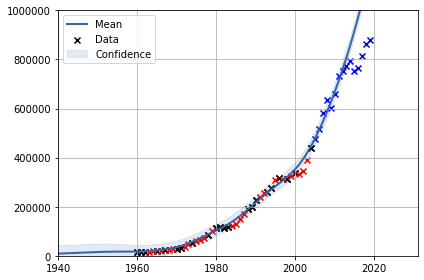

params:[8.75562771e-48 6.05467646e-02]
validate_rmse: 8926.423347402926 
 test_rmse: 94351.63909883797



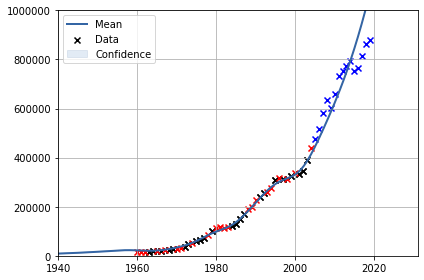

In [17]:
kf = KFold(n_splits=2, random_state=42, shuffle=True)

for train, val in kf.split(x_tv):
    x_train, y_train, x_val, y_val = x_tv[train], y_tv[train], x_tv[val], y_tv[val]
    result = gp_regression(
                         x_train=x_train,y_train=y_train,
                         x_val=x_val,y_val=y_val,
                         x_test=x_test,y_test=y_test,ylim=[0,1000000],
                         mean_func=exp, init_params=(1,-0.001),
                         kernel = GPy.kern.RBF(1),)

  0%|          | 0/8 [00:00<?, ?it/s]

[('box_cox', 1), ('sa', 1)]
params:[ 1.60989894e-02 -2.77302312e+01]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 13272.449579975162 
 test_rmse: 643137.9881385732



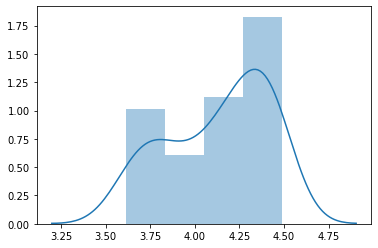

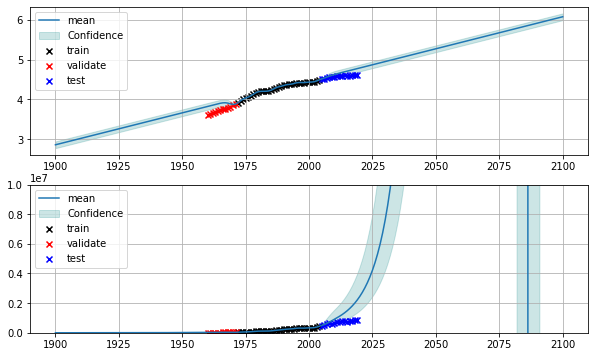

params:[ 2.03908851e-02 -3.63850545e+01]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 19501.606223794894 
 test_rmse: 2145961.3549120696



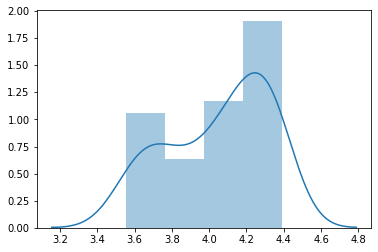

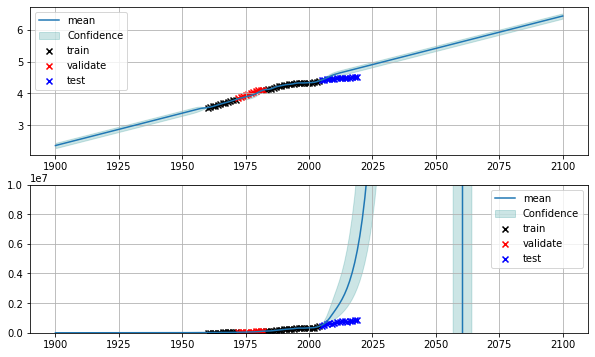

params:[ 1.92184506e-02 -3.40665226e+01]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 44591.61147834946 
 test_rmse: 1616507.9469207616



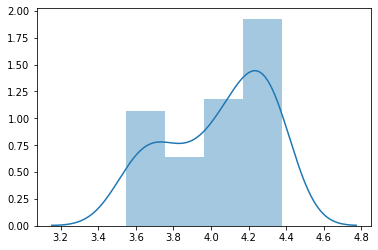

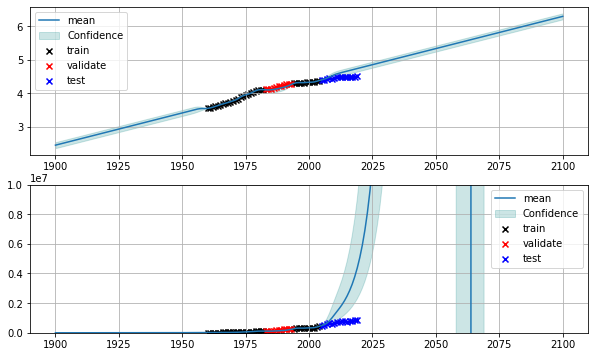

params:[ 2.51230517e-02 -4.55879470e+01]
(('box_cox', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 641276.1189240384 
 test_rmse: 11977583.163251834



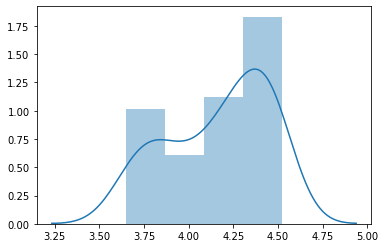

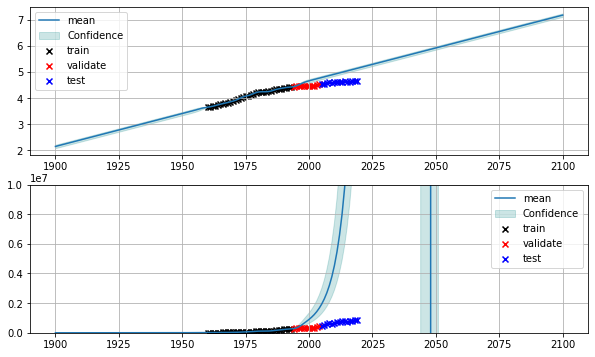

 12%|█▎        | 1/8 [00:02<00:18,  2.63s/it]

params:[ 1.3398270e-01 -2.6552777e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 15853.340748849525 
 test_rmse: 154403.69432458162



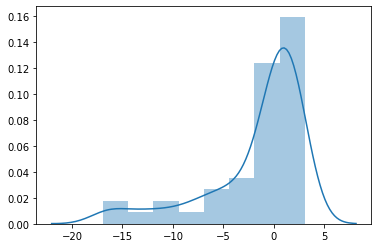

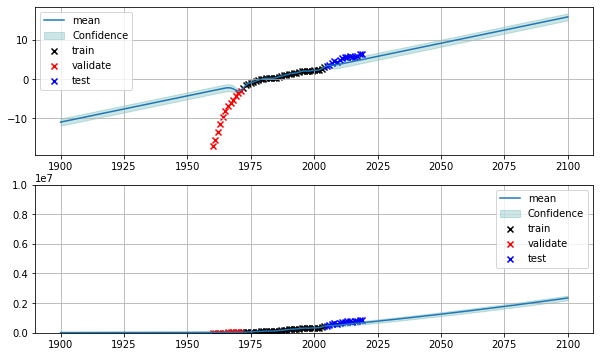

params:[ 1.24869253e-01 -2.46926282e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 21095.94151173002 
 test_rmse: 49751.420756630934



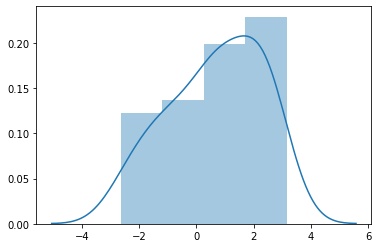

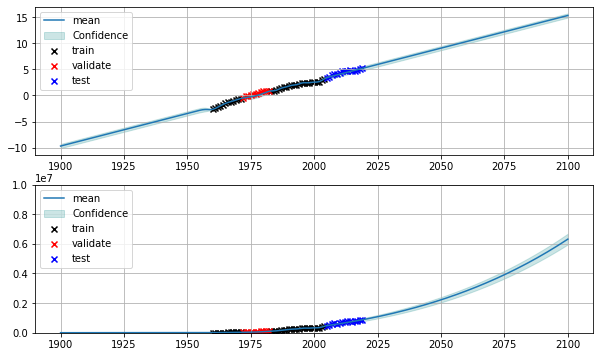

params:[ 1.16561281e-01 -2.30510664e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 28679.86780984412 
 test_rmse: 47974.31083014832



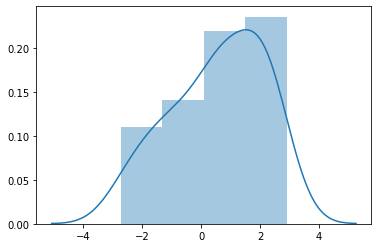

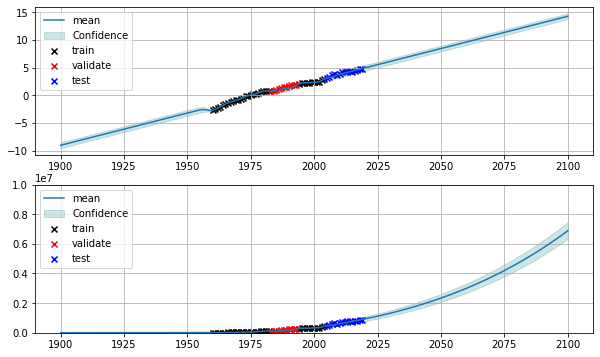

params:[ 1.62064473e-01 -3.19953957e+02]
(('box_cox', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 38097.33672583069 
 test_rmse: 104384.28706670144



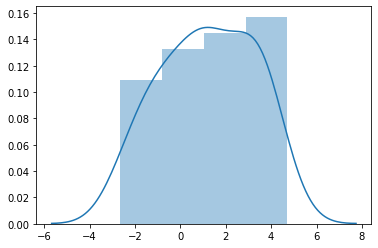

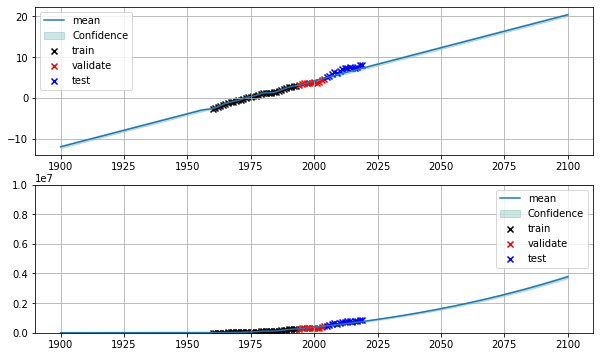

 25%|██▌       | 2/8 [00:05<00:16,  2.77s/it]

params:[ 1.32092309e-01 -2.62737938e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 15922.448529399375 
 test_rmse: 174900.13792353455



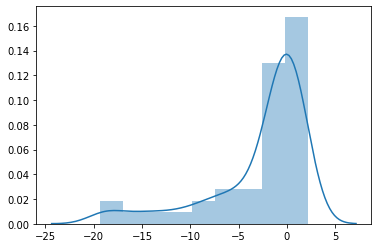

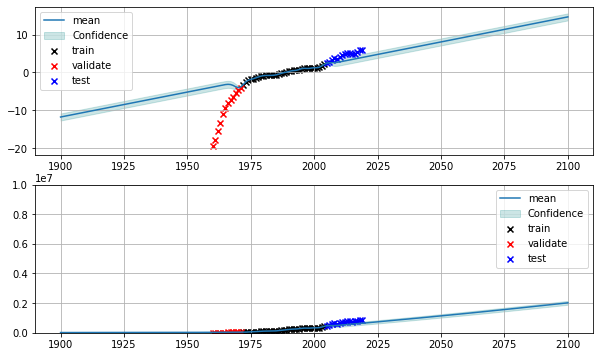

params:[ 1.23733799e-01 -2.45319895e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 16903.073063484375 
 test_rmse: 214502.80080864328



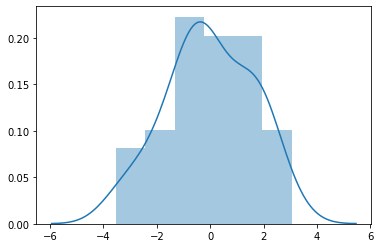

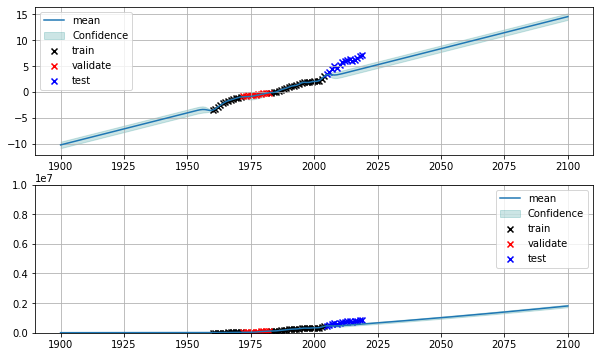

params:[ 1.14078193e-01 -2.26471306e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 23264.12230266875 
 test_rmse: 103031.22191604636



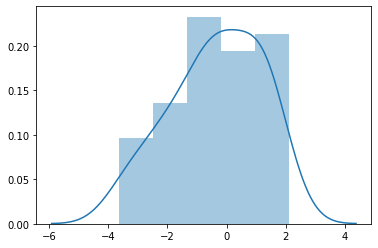

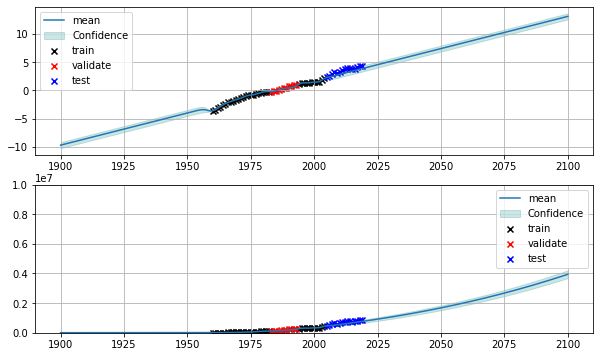

params:[ 1.57264095e-01 -3.11349924e+02]
(('box_cox', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 23611.551848636464 
 test_rmse: 212709.71142818718



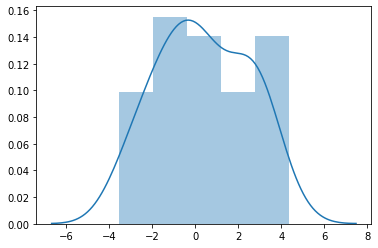

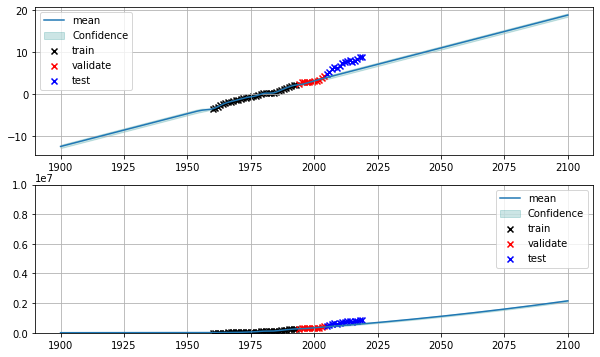

 38%|███▊      | 3/8 [00:08<00:14,  2.83s/it]

params:[ 1.33970174e-01 -2.65510716e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 15822.888598977837 
 test_rmse: 156168.35376342348



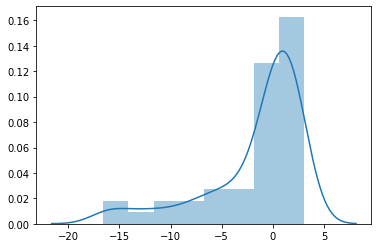

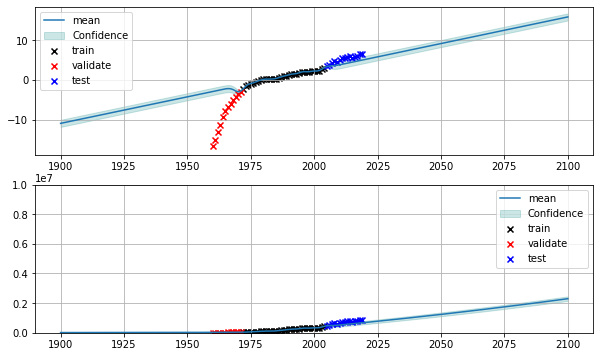

params:[ 1.24871048e-01 -2.46939416e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 21071.371147351532 
 test_rmse: 53028.61640652232



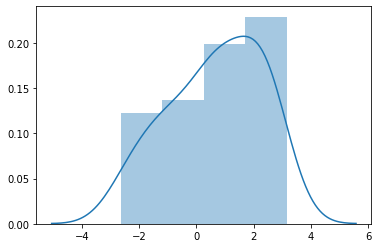

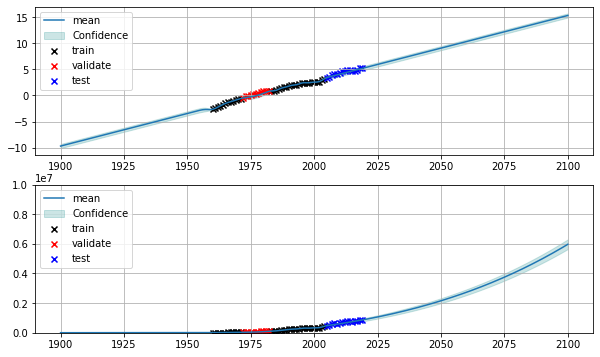

params:[ 1.16613089e-01 -2.30624100e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 28476.610035960064 
 test_rmse: 49316.25592793463



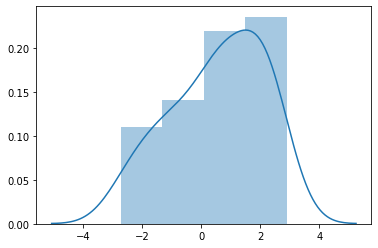

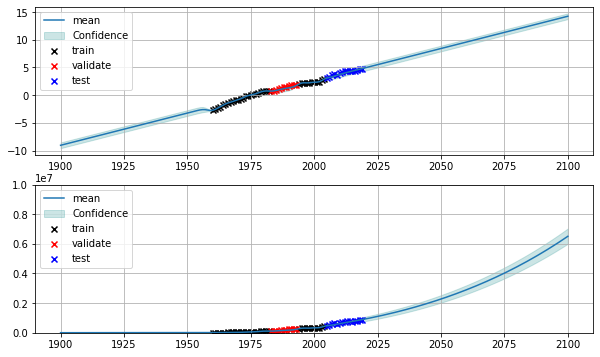

params:[ 1.62082207e-01 -3.19998956e+02]
(('box_cox', 1), ('sa', 1), ('sa', 1))
validate_rmse: 36368.45885574876 
 test_rmse: 111785.23238635488



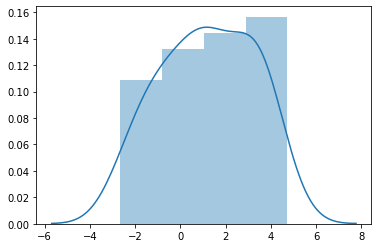

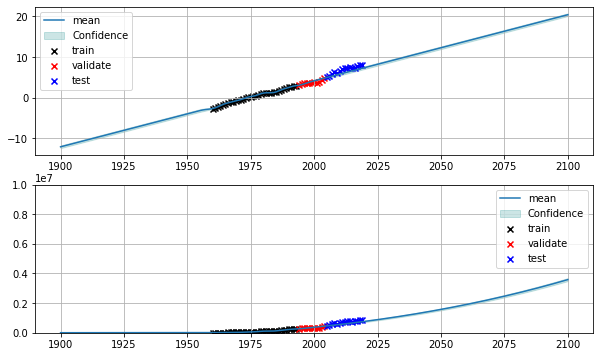

 50%|█████     | 4/8 [00:11<00:11,  2.80s/it]

params:[ 1.41687475e-01 -2.83203059e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 13228.365865456346 
 test_rmse: 164663.334463698



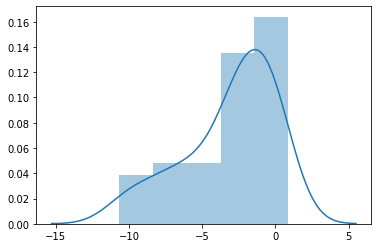

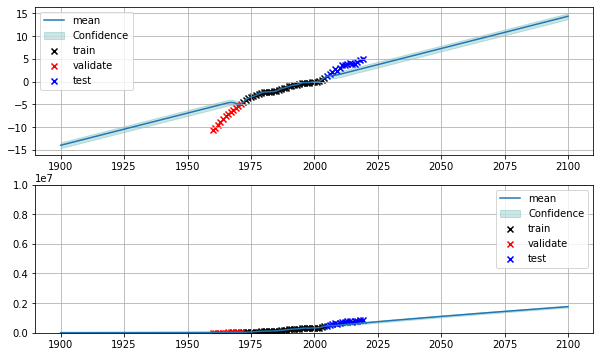

params:[ 1.20547470e-01 -2.40353796e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 25322.796275964643 
 test_rmse: 252651.20268825052



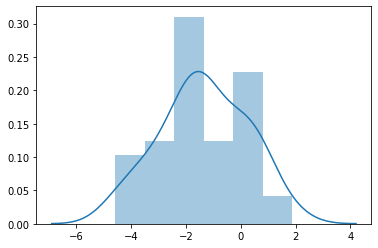

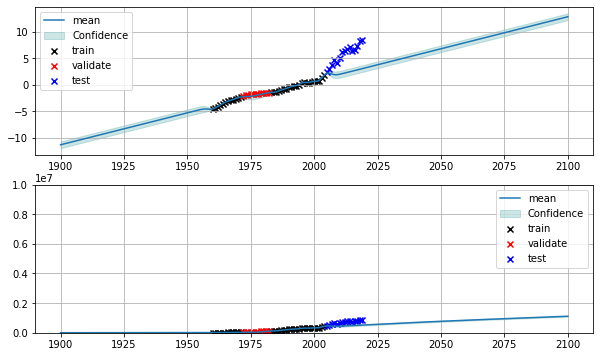

params:[ 1.11482605e-01 -2.22515479e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 23674.21096825957 
 test_rmse: 197225.93691053323



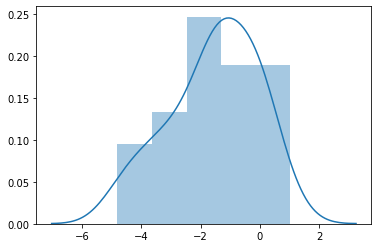

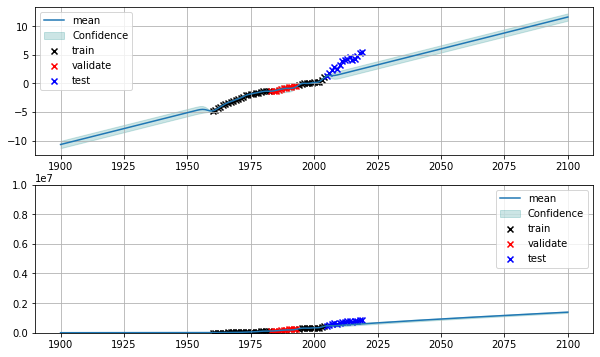

params:[ 1.60299684e-01 -3.18733173e+02]
(('sa', 1), ('box_cox', 1), ('box_cox', 1))
validate_rmse: 32594.195992618923 
 test_rmse: 271767.5246881562



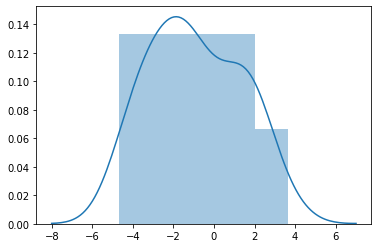

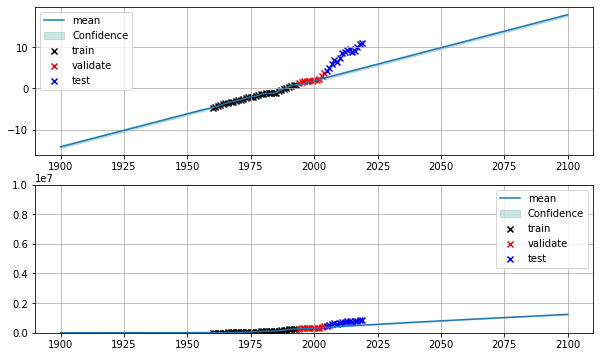

 62%|██████▎   | 5/8 [00:15<00:09,  3.23s/it]

params:[ 1.36407652e-01 -2.71191549e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 11441.44990854418 
 test_rmse: 234684.10004550402



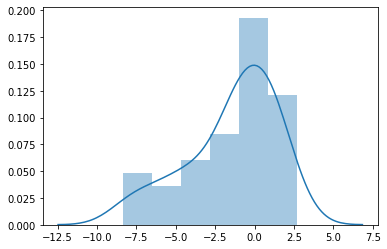

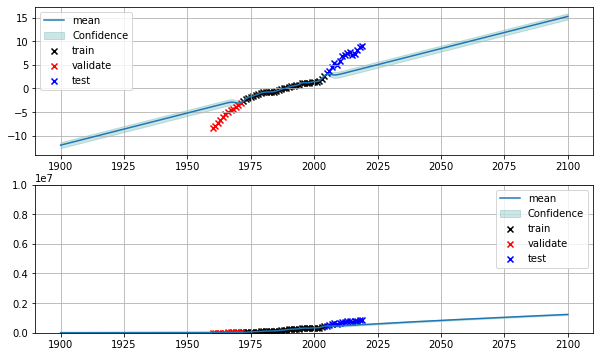

params:[ 1.04317995e-01 -2.06918626e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 19180.193504315204 
 test_rmse: 265597.75938777236



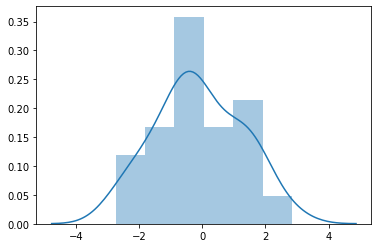

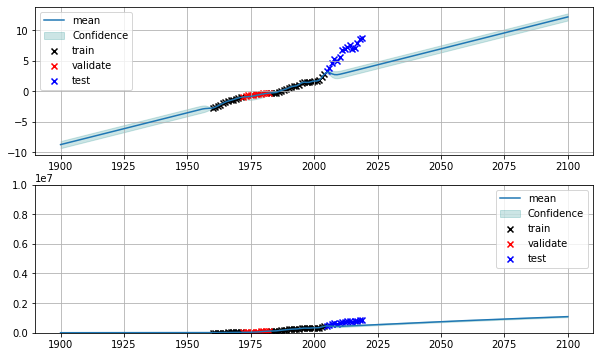

params:[ 1.09884232e-01 -2.18014111e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 22594.70975084035 
 test_rmse: 232929.74941051987



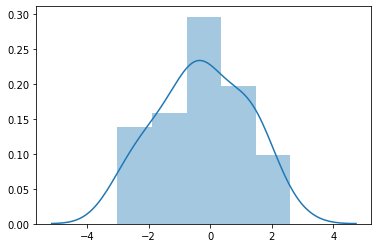

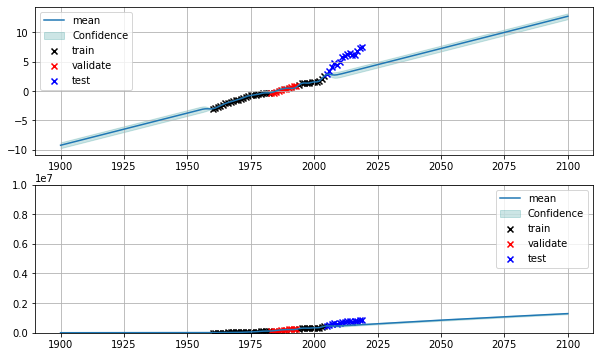

params:[ 1.51567438e-01 -2.99995979e+02]
(('sa', 1), ('box_cox', 1), ('sa', 1))
validate_rmse: 58420.957687789174 
 test_rmse: 343186.72521290026



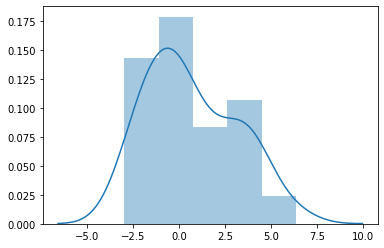

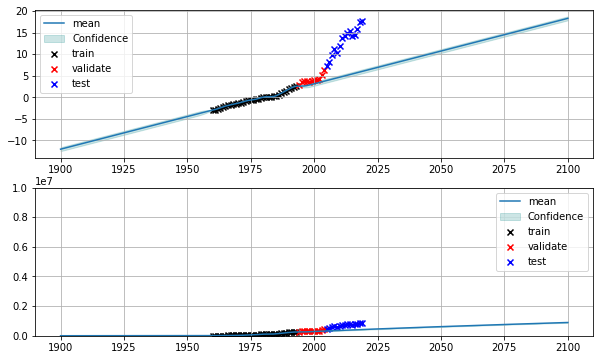

 75%|███████▌  | 6/8 [00:17<00:06,  3.09s/it]

params:[ 1.37561589e-01 -2.73933543e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 14392.475653042688 
 test_rmse: 176825.47594676638



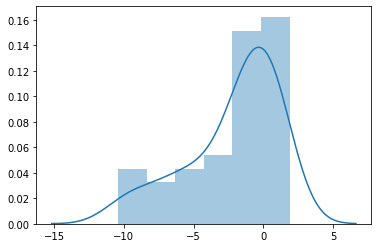

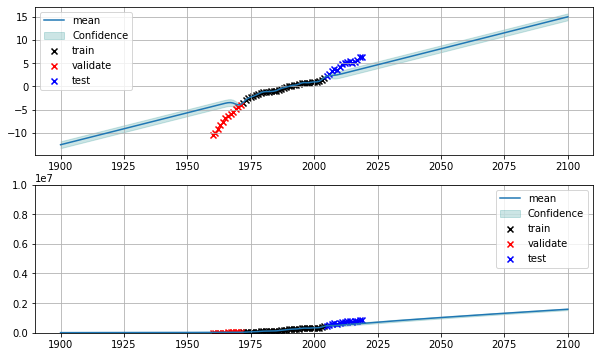

params:[ 1.19906875e-01 -2.38064082e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 26734.03144881424 
 test_rmse: 255405.58327236143



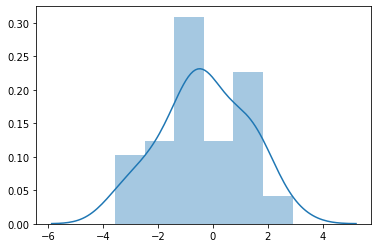

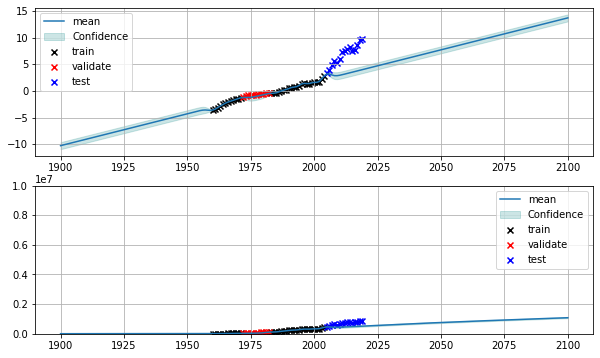

params:[ 1.13593171e-01 -2.25780378e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 20590.397836940745 
 test_rmse: 185865.56116621263



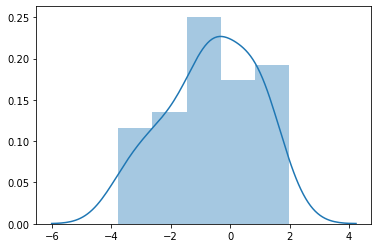

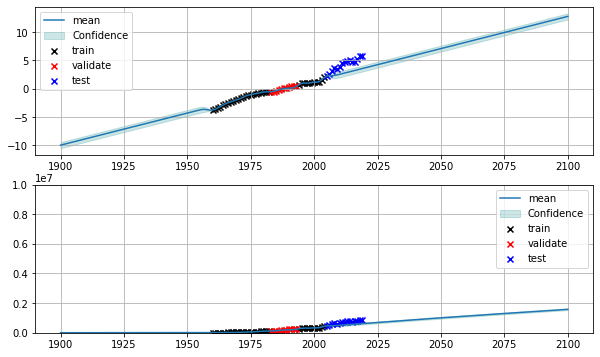

params:[ 1.58068531e-01 -3.13233510e+02]
(('sa', 1), ('sa', 1), ('box_cox', 1))
validate_rmse: 35508.366455365416 
 test_rmse: 288806.55611278693



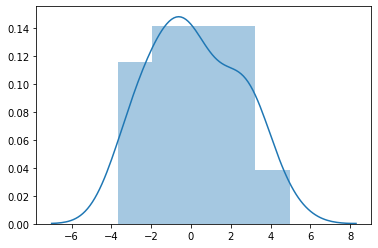

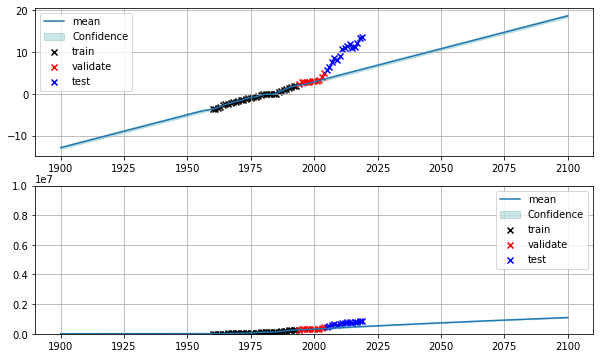

 88%|████████▊ | 7/8 [00:22<00:03,  3.41s/it]

params:[ 1.33182454e-01 -2.64165264e+02]
(('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 14889.519875556036 
 test_rmse: 198379.9696425483



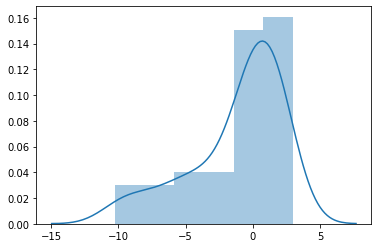

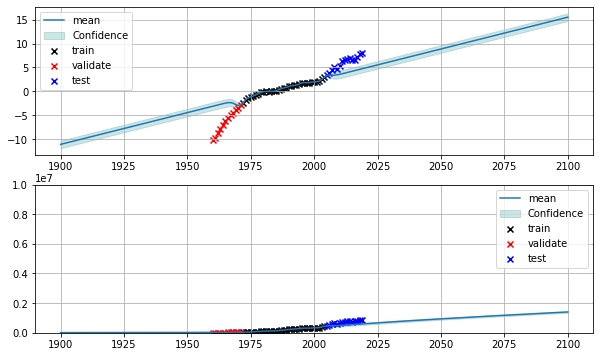

params:[ 1.23421796e-01 -2.44326329e+02]
(('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 20292.52032042619 
 test_rmse: 159489.4469301168



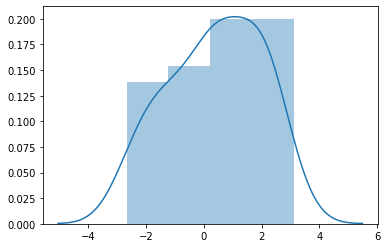

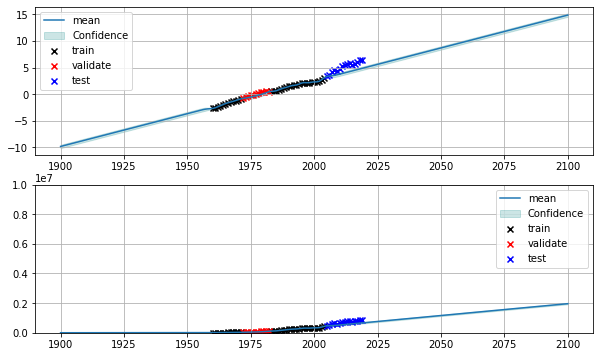

params:[ 1.17246731e-01 -2.32172633e+02]
(('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 23620.76497404287 
 test_rmse: 140928.17136543503



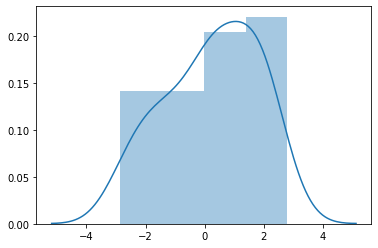

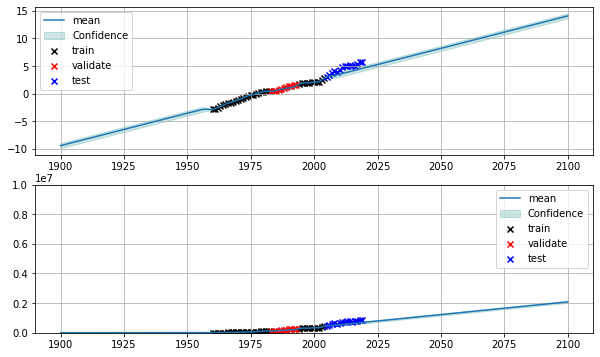

params:[ 1.61833409e-01 -3.19757657e+02]
(('sa', 1), ('sa', 1), ('sa', 1))
validate_rmse: 25542.02198309152 
 test_rmse: 254047.41191082034



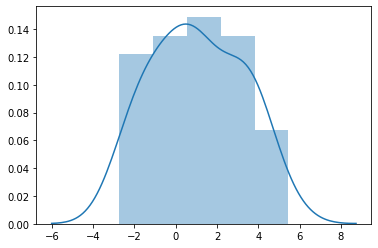

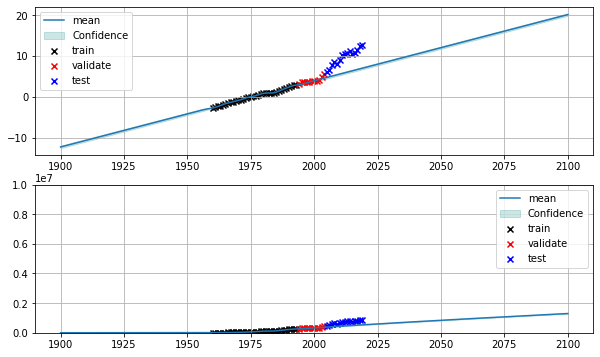

100%|██████████| 8/8 [00:25<00:00,  3.20s/it]


In [19]:
result = grid_search(cwgp_regression, x_tv, y_tv, {"c":3,"n":[1],"transformations":["box_cox","sa"]},
                    cv=True, n_splits=4, shuffle=False, random_state=None,
                     x_test=x_test,y_test=y_test,ylim=[0,10000000],
                     mean_func=poly, init_params=(1,-0.1),
                     kernel = GPy.kern.RBF(1),
                    )